In [36]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
from __future__ import print_function
import numpy as np
import tensorflow as tf
from six.moves import cPickle as pickle
from six.moves import range
import os

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
url = 'http://ufldl.stanford.edu/housenumbers/'
train_filename = 'train.tar.gz'
test_filename = 'test.tar.gz'

last_percent_reported = None

def download_progress_hook(count, blockSize, totalSize):
    """A hook to report the progress of a download. This is mostly intended for users with
    slow internet connections. Reports every 1% change in download progress.
    """
    global last_percent_reported
    percent = int(count * blockSize * 100 / totalSize)

    if last_percent_reported != percent:
        if percent % 5 == 0:
            sys.stdout.write("%s%%" % percent)
            sys.stdout.flush()
        else:
            sys.stdout.write(".")
            sys.stdout.flush()

        last_percent_reported = percent

def maybe_download(filename, expected_bytes, force=False):
    """Download a file if not present, and make sure it's the right size."""
    if force or not os.path.exists(filename):
        print('Attempting to download:', filename) 
        filename, _ = urlretrieve(url + filename, filename, reporthook=download_progress_hook)
        print('\nDownload Complete!')
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print('Found and verified', filename)
    else:
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

maybe_download(train_filename, 404141560)
maybe_download(test_filename, 276555967)

Found and verified train.tar.gz
Found and verified test.tar.gz


'test.tar.gz'

In [4]:
num_classes = 10
np.random.seed(133)

def maybe_extract(filename, force=False):
    root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
    if os.path.isdir(root) and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extraction of %s.' % (root, filename))
    else:
        print('Extracting data for %s. This may take a while. Please wait.' % root)
        tar = tarfile.open(filename)
        sys.stdout.flush()
        tar.extractall()
        tar.close()
  
maybe_extract(train_filename)
maybe_extract(test_filename)

train already present - Skipping extraction of train.tar.gz.
test already present - Skipping extraction of test.tar.gz.


In [130]:
import json

def load_file_meta(filename):
    results = {}
    with open(filename) as data_file:    
        data = json.load(data_file)
    
    for file_info in data:
        pic_labels = [int(item['label']) for item in file_info['boxes']]
#         boxes = [(item['top'],
#                   item['left'],
#                   item['height'],
#                   item['width'])
#                 for item in file_info['boxes']]
        results[file_info['filename']] = pic_labels
    return results
    
train_info = load_file_meta('train/digitStruct.json')
test_info = load_file_meta('test/digitStruct.json')

print([(a, train_info[a]) for a in train_info.keys()[:5]])
    
img_width = 160
img_height = 90    

[(u'4833.png', [5, 2, 7]), (u'32624.png', [6]), (u'28190.png', [6]), (u'25708.png', [1, 1]), (u'25267.png', [4, 4, 1])]


test


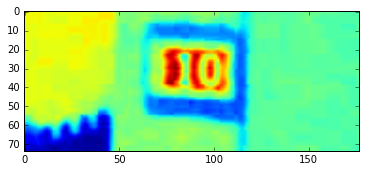

Original (74, 177)


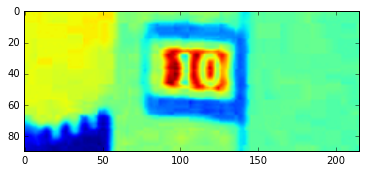

Zoomed (90, 215)


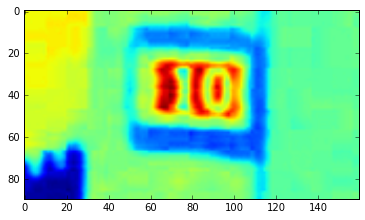

Cropped (90, 160)


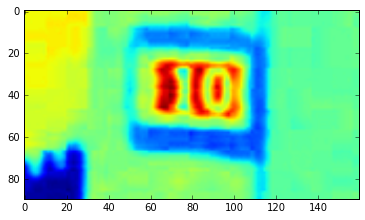

Color ranged: 0.5 -0.5
Filename:1619.png
Label:[1, 10]


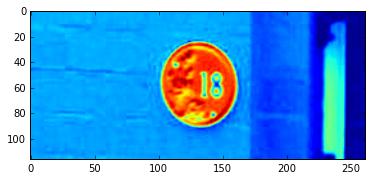

Original (116, 262)


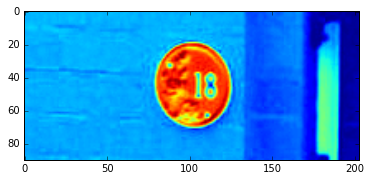

Zoomed (90, 203)


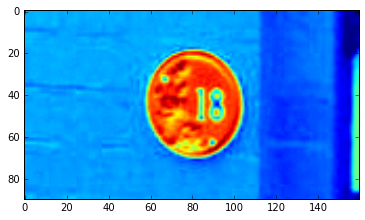

Cropped (90, 160)


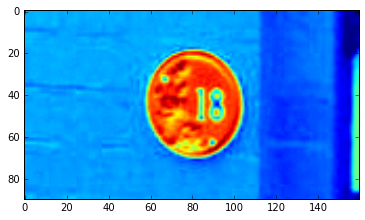

Color ranged: 0.5 -0.5
Filename:13053.png
Label:[1, 8]


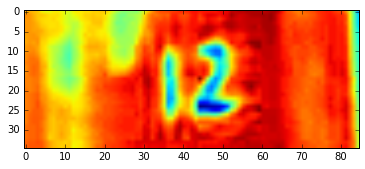

Original (35, 85)


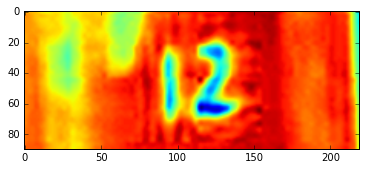

Zoomed (90, 219)


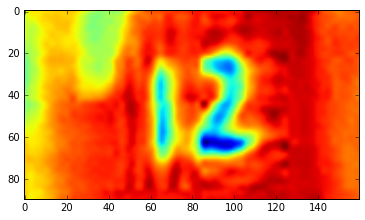

Cropped (90, 160)


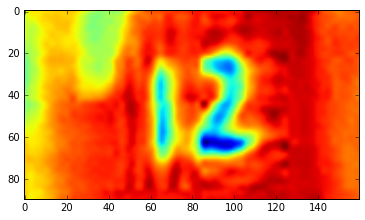

Color ranged: 0.5 -0.5
Filename:4792.png
Label:[1, 2]


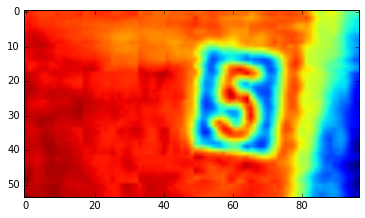

Original (54, 97)


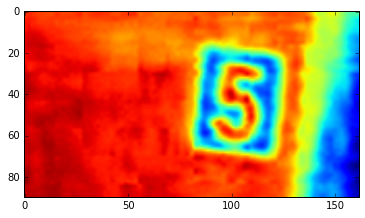

Zoomed (90, 162)


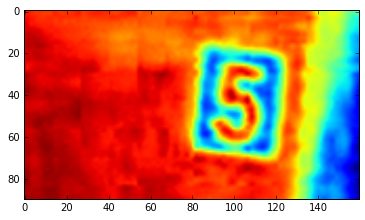

Cropped (90, 160)


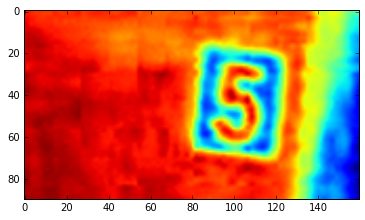

Color ranged: 0.5 -0.5
Filename:10340.png
Label:[5]


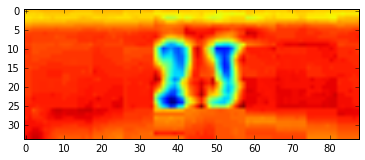

Original (34, 88)


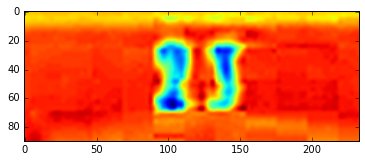

Zoomed (90, 233)


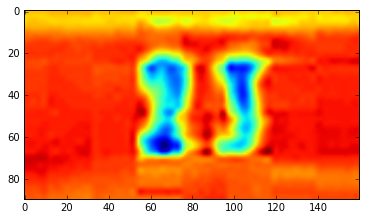

Cropped (90, 160)


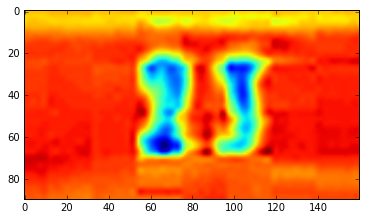

Color ranged: 0.5 -0.5
Filename:4484.png
Label:[2, 3]


In [131]:
pixel_depth = 255.0  # Number of levels per pixel.
import os
from scipy import ndimage
import scipy.misc as spm
import scipy.ndimage as spn

screen_ratio = 1080./1920.

def load_images(folder, pic_info, min_num_images, show=False):
    """Load the data for a single letter label."""
    image_files = os.listdir(folder)

    result = []

    print(folder)
    num_images = 0
  
    for image in np.random.choice(image_files, min_num_images):
        image_file = os.path.join(folder, image)

        image_data = (ndimage.imread(image_file, flatten=True).astype(float) - 
                    pixel_depth / 2) / pixel_depth

        ratio = 1.0 * image_data.shape[0] / image_data.shape[1]

        if ratio < screen_ratio:
            factor = 1.0 * img_height / image_data.shape[0]
        else:
            factor = 1.0 * img_width / image_data.shape[1]

        img = spn.interpolation.zoom(image_data, factor)
        
        y = (img.shape[0] - img_height) // 2
        x = (img.shape[1] - img_width) // 2

        img_resized = img[y:y + img_height, x:x+img_width]
        
        img_colors = img_resized.astype(np.float32) - np.min(img_resized)
        img_colors = img_colors / np.max(img_colors) - 0.5

        if show:        
            plt.imshow(image_data)
            plt.show()
            print("Original", image_data.shape)
            plt.imshow(img)
            plt.show()
            print("Zoomed", img.shape)
            plt.imshow(img_resized)
            plt.show()
            print("Cropped", img_resized.shape)
            plt.imshow(img_colors)
            plt.show()
            print("Color ranged:", np.max(img_colors), np.min(img_colors))
            print("Filename:%s" % image)
            print("Label:%s" % pic_info[image])
            
        result.append(img_resized)
    return result
        
tmp_images = load_images('test', test_info, 5, show=True)
        


In [6]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

In [7]:
pickle_file = 'notMNIST_clean.pickle'

with open(pickle_file, 'rb') as f:
  save = pickle.load(f)
  train_dataset_raw = save['train_dataset']
  train_labels_raw = save['train_labels']
  valid_dataset_raw = save['valid_dataset']
  valid_labels_raw = save['valid_labels']
  test_dataset_raw = save['test_dataset']
  test_labels_raw = save['test_labels']
  del save  # hint to help gc free up memory
  print('Training set', train_dataset_raw.shape, train_labels_raw.shape)
  print('Validation set', valid_dataset_raw.shape, valid_labels_raw.shape)
  print('Test set', test_dataset_raw.shape, test_labels_raw.shape)

Training set (200000, 28, 28) (200000,)
Validation set (8913, 28, 28) (8913,)
Test set (8695, 28, 28) (8695,)


In [8]:
image_size = 28
num_labels = 11 # Add an extra character so we can deal with spaces
num_channels = 1 # grayscale

import numpy as np

def reformat(dataset, labels):
  dataset = dataset.reshape(
    (-1, image_size, image_size, num_channels)).astype(np.float32) # Conv net
    #(-1, image_size, image_size)).astype(np.float32)  # Deep net
  labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
  return dataset, labels
train_dataset, train_labels = reformat(train_dataset_raw, train_labels_raw)
valid_dataset, valid_labels = reformat(valid_dataset_raw, valid_labels_raw)
test_dataset, test_labels = reformat(test_dataset_raw, test_labels_raw)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (200000, 28, 28, 1) (200000, 11)
Validation set (8913, 28, 28, 1) (8913, 11)
Test set (8695, 28, 28, 1) (8695, 11)


In [12]:
# Clean up after ourselves
%reset_selective -f .*_raw

In [13]:
# Create an empty character
empty_label = np.zeros(num_labels)
empty_label[-1] = 1.
print(empty_label)
print(train_labels[:10])

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
[[ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]]


With training data
Image shape: (48, 440, 1)


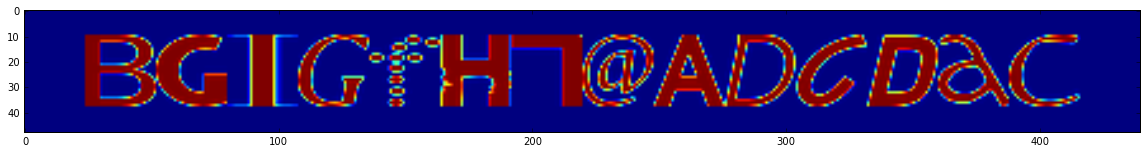

Label shape: (15, 11)
BGIGFHIDADCDAC.
With testing data
Image shape: (48, 300, 1)


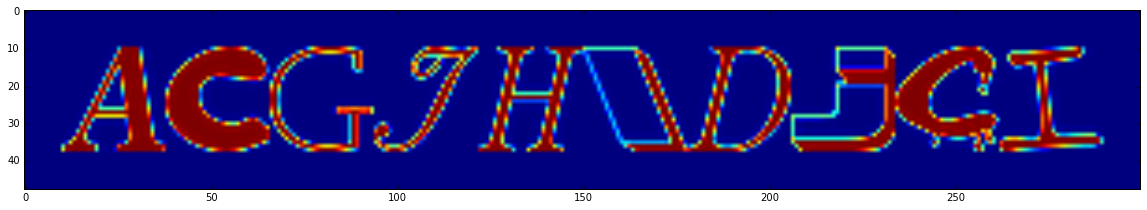

Label shape: (10, 11)
ACGIHIDJCI
Image shape: (48, 160, 1)


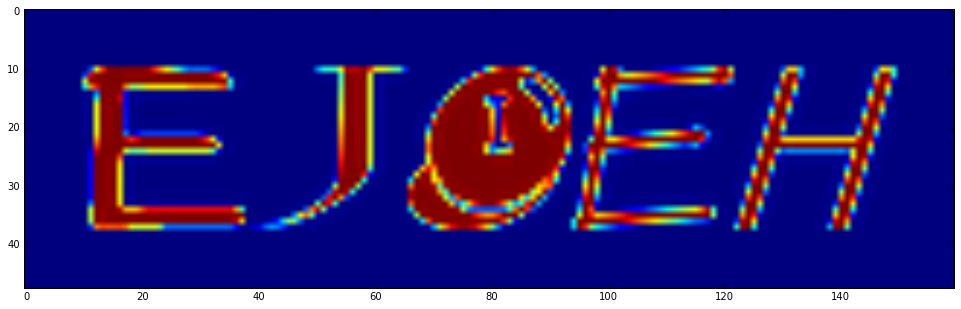

Label shape: (5, 11)
EJIEH
Image shape: (48, 160, 1)


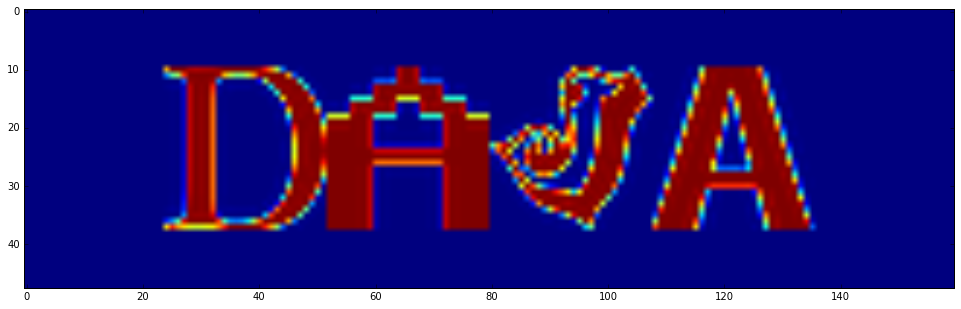

Label shape: (5, 11)
DAJA.
Image shape: (48, 160, 1)


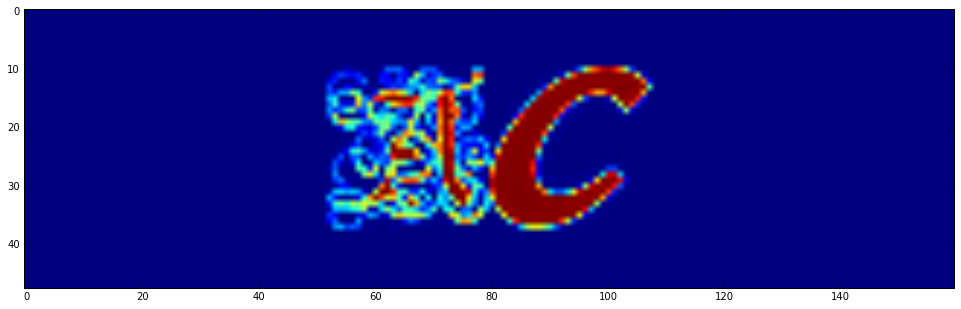

Label shape: (5, 11)
.AC..


In [16]:
# Create a sequence of digits from the training data
#
# returns (joined image, labels)
def create_sequence(train, labels, length=5):
    rand_length = np.random.randint(length) + 1
        
    spacing = 10
    digit_height = train.shape[1]
    digit_width = train.shape[2]
    
    img_height = digit_height + spacing * 2
    img_width = digit_width * length + spacing * 2
    
    result_image = np.ones([img_height, img_width, num_channels]).astype(np.float32) * -0.5
    
    x = spacing + int(digit_width * (length - rand_length) / 2.)
    y = spacing
    
    result_labels = [empty_label] * length
    
    for a in range(rand_length):
        # Choose random indexes for the digits
        index = np.random.randint(0, labels.shape[0])
        
        img = train[index]
        
        #print(y,digit_height, x, digit_width)
        result_image[y:y+digit_height, x:x+digit_width, :] = img
        x = x + digit_width
        
        result_labels[(length - rand_length) // 2 + a] = labels[index]
    
    result_labels = np.array(result_labels)
    
    return result_image, result_labels
           
def show_image(data):
    print("Image shape:", data.shape)
    plt.figure(figsize=(20, 5))
    plt.imshow(np.reshape(data, data.shape[:2]))
    plt.show()
    
def show_label(label):
    print("Label shape:", label.shape)
    result = ''
    for a in label:
        index = np.argmax(a)
        if index + 1 == len(empty_label):
            result += '.'
        else:
            result += chr(ord('A') + index)
    print(result)
    
print("With training data")
tmp_image, tmp_label = create_sequence(train_dataset, train_labels, length=15)
show_image(tmp_image)
show_label(tmp_label)

print("With testing data")
tmp_image, tmp_label = create_sequence(test_dataset, test_labels, length=10)
show_image(tmp_image)
show_label(tmp_label)

# Create a batch of images and labels
def generate_batch(data, labels, size, length, **kwargs):
    images, labels = zip(*[create_sequence(data, labels, length, **kwargs) for i in range(size)])
        
    result_images = np.array(images)
    result_labels = np.array(labels)
    
    return result_images, result_labels

tmp_images, tmp_labels = generate_batch(train_dataset, train_labels, 3, 5)

for i in range(len(tmp_labels)):
    show_image(tmp_images[i])
    show_label(tmp_labels[i])
    
%reset_selective -f tmp_.*

Validation shape: (1000, 48, 160, 1) (1000, 5, 11)
Testing shape: (2500, 48, 160, 1) (2500, 5, 11)
Image shape: (48, 160, 1)


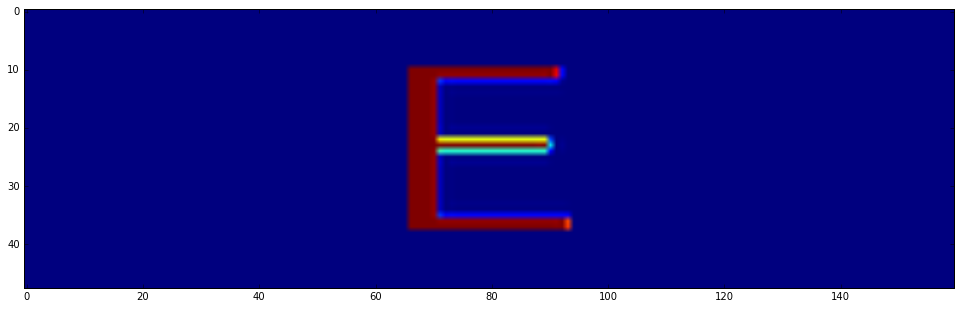

Label shape: (5, 11)
..E..
Image shape: (48, 160, 1)


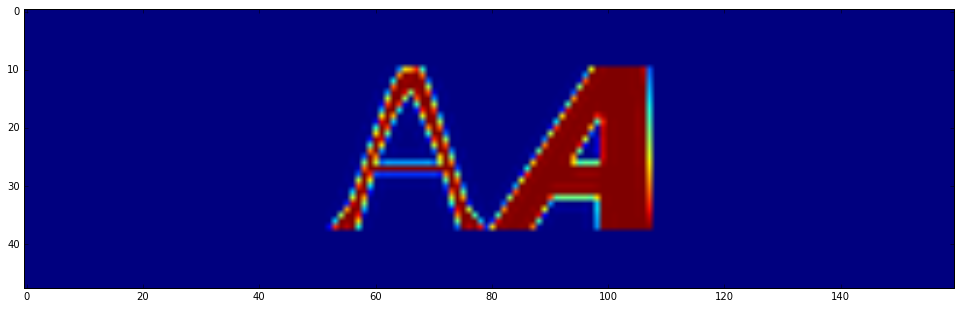

Label shape: (5, 11)
.AA..


In [17]:
# Lets create our training, validation and testing datasets
num_digits = 5

#train_dataset_imgs, train_dataset_labels = generate_batch(train_dataset, train_labels, 10000, num_digits)
valid_dataset_imgs, valid_dataset_labels = generate_batch(valid_dataset, valid_labels, 1000, num_digits)
test_dataset_imgs, test_dataset_labels = generate_batch(test_dataset, test_labels, 2500, num_digits)

#print("Training shape:", train_dataset_imgs.shape, train_dataset_labels.shape)
print("Validation shape:", valid_dataset_imgs.shape, valid_dataset_labels.shape)
print("Testing shape:", test_dataset_imgs.shape, test_dataset_labels.shape)

# show_image(train_dataset_imgs[110])
# show_label(train_dataset_labels[110])
show_image(valid_dataset_imgs[110])
show_label(valid_dataset_labels[110])
show_image(test_dataset_imgs[110])
show_label(test_dataset_labels[110])

In [18]:

batch_size = 16
patch_size = 5
depth = 16
num_hidden = 64

graph = tf.Graph()

img_height, img_width = test_dataset_imgs[0].shape[:2]

with graph.as_default():

  # Input data.
  tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size,
                                                       img_height,
                                                       img_width,
                                                       num_channels), name="tf_train_dataset")
    
  tf_train_labels = [tf.placeholder(tf.float32, shape=(batch_size,
                                                      num_labels), name="tf_train_labels_%d" % i)
                     for i in range(num_digits)]
  tf_valid_dataset = tf.constant(valid_dataset_imgs, name="tf_valid_dataset")
  tf_test_dataset = tf.constant(test_dataset_imgs, name="tf_test_dataset")
  
  # Variables.
  layer1_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    num_channels,
                                                    depth], stddev=0.1), name="layer1_weights")
  layer1_biases = tf.Variable(tf.zeros([depth]), name="layer1_biases")

  layer2_weights = tf.Variable(tf.truncated_normal([patch_size,
                                                    patch_size,
                                                    depth,
                                                    depth], stddev=0.1), name="layer2_weights")
  layer2_biases = tf.Variable(tf.constant(1.0, shape=[depth]), name="layer2_biases")

  layer3_weights = tf.Variable(tf.truncated_normal([img_height // 4 * img_width // 4 * depth,
                                                    num_hidden], stddev=0.1), name="layer3_weights")
    
  layer3_biases = tf.Variable(tf.constant(1.0, shape=[num_hidden]), name="layer3_biases")

  layer4_weights = [tf.Variable(tf.truncated_normal([num_hidden,
                                                    num_labels], stddev=0.1), name="layer4_weights")
                    for i in range(num_digits)]
  layer4_biases = [tf.Variable(tf.constant(1.0, shape=[num_labels]), name="layer4_biases")
                   for i in range(num_digits)]

   
    
  # Model.
  def model(data):
    conv = tf.nn.conv2d(data, layer1_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer1_biases)
    conv = tf.nn.conv2d(hidden, layer2_weights, [1, 2, 2, 1], padding='SAME')
    hidden = tf.nn.relu(conv + layer2_biases)
    shape = hidden.get_shape().as_list()
    reshape = tf.reshape(hidden, [shape[0], shape[1] * shape[2] * shape[3]])
    hidden = tf.nn.relu(tf.matmul(reshape, layer3_weights) + layer3_biases)
    output = [tf.matmul(hidden, layer4_weights[i]) + layer4_biases[i]
              for i in range(num_digits)]
    return output
  
  # Training computation.
  logits = model(tf_train_dataset)
  loss = tf.reduce_mean([
    tf.nn.softmax_cross_entropy_with_logits(logits[i], tf_train_labels[i])
        for i in range(num_digits)])
    
  # Optimizer.
  optimizer = tf.train.GradientDescentOptimizer(0.05).minimize(loss)
  
  # Predictions for the training, validation, and test data.
  train_prediction = [tf.nn.softmax(a) for a in logits]
  valid_prediction = [tf.nn.softmax(a) for a in model(tf_valid_dataset)]
  test_prediction = [tf.nn.softmax(a) for a in model(tf_test_dataset)]

In [23]:
num_steps = 1001

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print('Initialized')
    for step in range(num_steps):    

        batch_data, batch_labels = generate_batch(train_dataset, train_labels, batch_size, num_digits)

        feed_dict = {tf_train_dataset : batch_data}
        for i in range(num_digits):
            labels = batch_labels[:, i, :]
            feed_dict[tf_train_labels[i]] = labels

        fetches = [optimizer, loss] + train_prediction
        results = session.run(fetches, feed_dict=feed_dict)
        
        if (step % 50 == 0):
            print('Minibatch loss at step %d: %f' % (step, results[1]))               
            print('Minibatch accuracy: %.1f%%' % np.mean([accuracy(results[2+i], batch_labels[:, i, :])
                                                        for i in range(num_digits)]))
            print('Validation accuracy: %.1f%%' % np.mean([accuracy(valid_prediction[i].eval(),
                                                                  valid_dataset_labels[:, i, :])
                                                         for i in range(num_digits)]))
            
        # Free up some memory
        %reset_selective -f batch_data
        %reset_selective -f batch_labels
        
    # Lets get these so we can investigate the predictions outside of the graph
    test_predictions = [test_prediction[i].eval()
                        for i in range(num_digits)]
    
    print('Test accuracy: %.1f%%' % np.mean([accuracy(test_predictions[i],
                                                      test_dataset_labels[:, i, :])
                                             for i in range(num_digits)]))
                                                    
                                                      
                                           

#   results = [layer1_weights.eval(),
#              layer1_biases.eval(),
#              layer2_weights.eval(),
#              layer2_biases.eval()]


Initialized
Minibatch loss at step 0: 5.261987
Minibatch accuracy: 26.2%
Validation accuracy: 19.9%
Minibatch loss at step 50: 1.774656
Minibatch accuracy: 37.5%
Validation accuracy: 44.8%
Minibatch loss at step 100: 1.474062
Minibatch accuracy: 50.0%
Validation accuracy: 46.1%
Minibatch loss at step 150: 1.358949
Minibatch accuracy: 48.8%
Validation accuracy: 46.6%
Minibatch loss at step 200: 1.468958
Minibatch accuracy: 47.5%
Validation accuracy: 47.2%
Minibatch loss at step 250: 1.384823
Minibatch accuracy: 46.2%
Validation accuracy: 48.5%
Minibatch loss at step 300: 1.674432
Minibatch accuracy: 37.5%
Validation accuracy: 48.2%
Minibatch loss at step 350: 0.993269
Minibatch accuracy: 61.2%
Validation accuracy: 50.7%
Minibatch loss at step 400: 1.344459
Minibatch accuracy: 47.5%
Validation accuracy: 50.8%
Minibatch loss at step 450: 1.203645
Minibatch accuracy: 56.2%
Validation accuracy: 50.8%
Minibatch loss at step 500: 1.303617
Minibatch accuracy: 50.0%
Validation accuracy: 51.2%
M

(5, 2500, 11)
Image shape: (48, 160, 1)


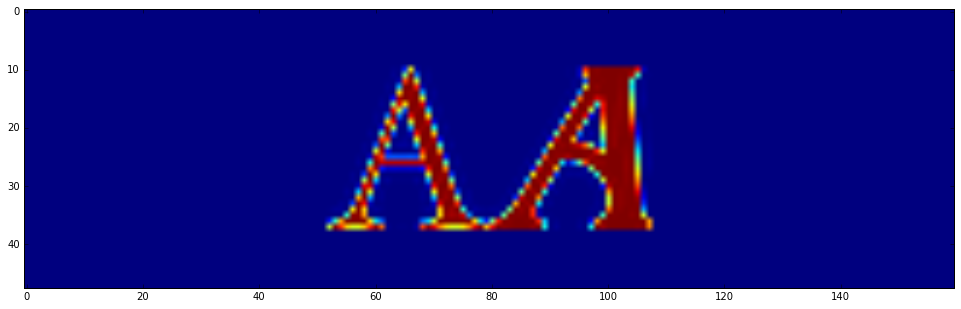

Label shape: (5, 11)
.AA..
Image shape: (48, 160, 1)


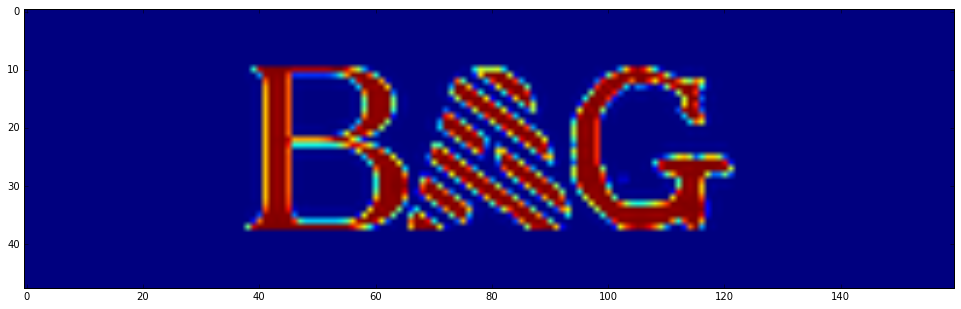

Label shape: (5, 11)
.BAC.
Image shape: (48, 160, 1)


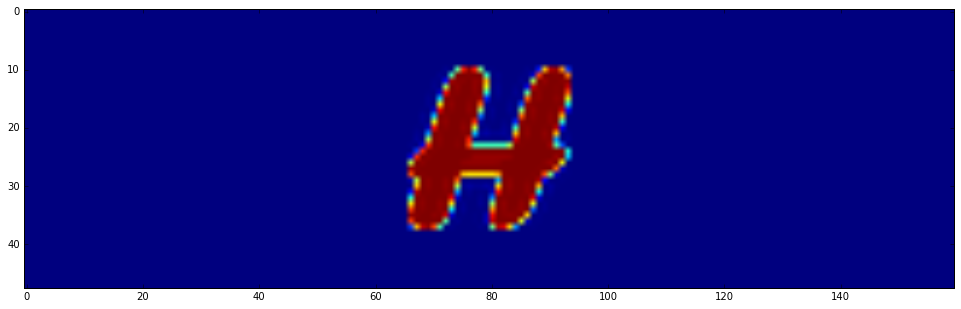

Label shape: (5, 11)
..H..
Image shape: (48, 160, 1)


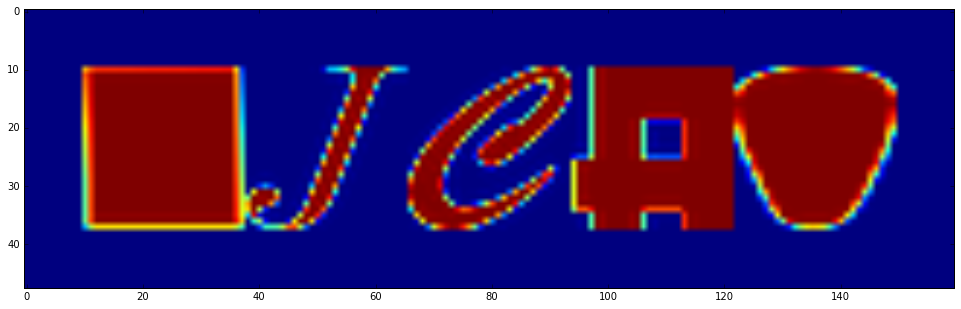

Label shape: (5, 11)
IADAJ
Image shape: (48, 160, 1)


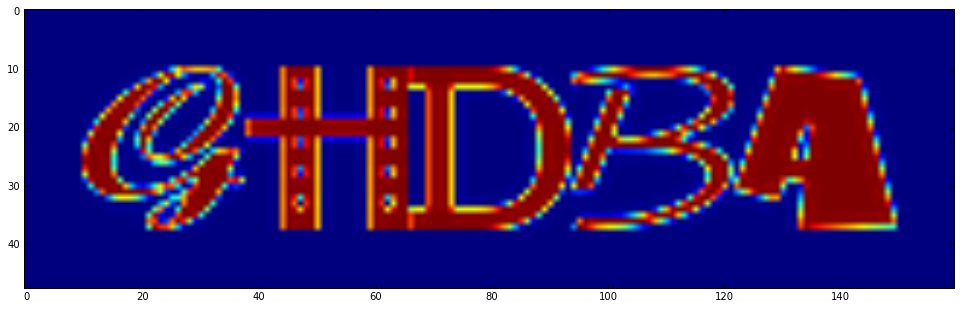

Label shape: (5, 11)
DAJJH
Image shape: (48, 160, 1)


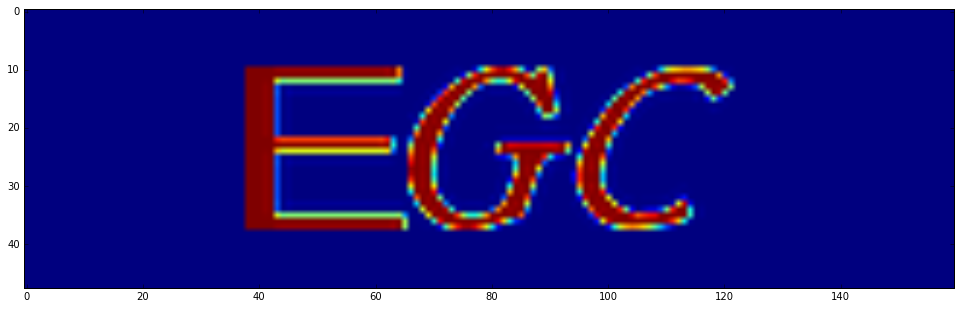

Label shape: (5, 11)
.EIF.
Image shape: (48, 160, 1)


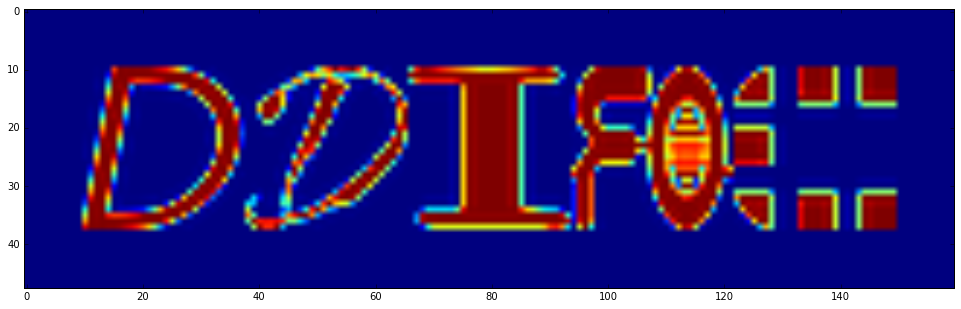

Label shape: (5, 11)
DAJID
Image shape: (48, 160, 1)


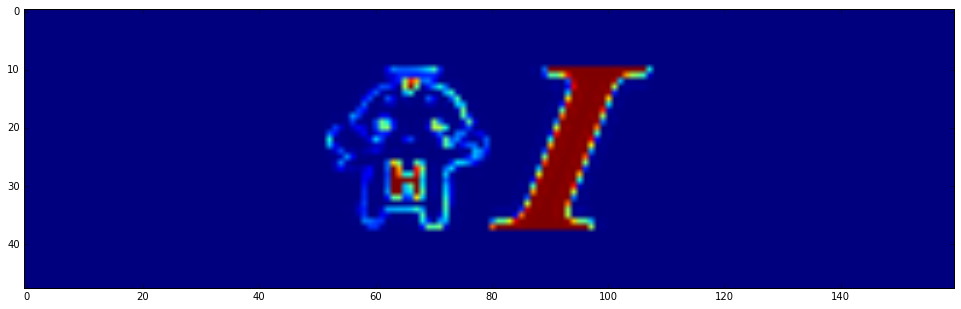

Label shape: (5, 11)
..A..
Image shape: (48, 160, 1)


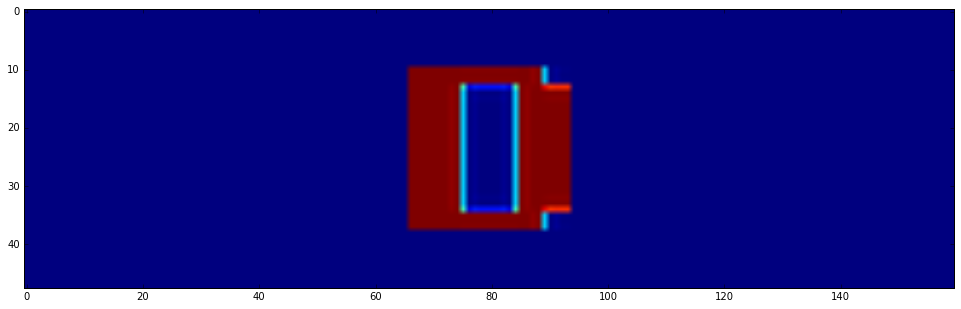

Label shape: (5, 11)
..D..
Image shape: (48, 160, 1)


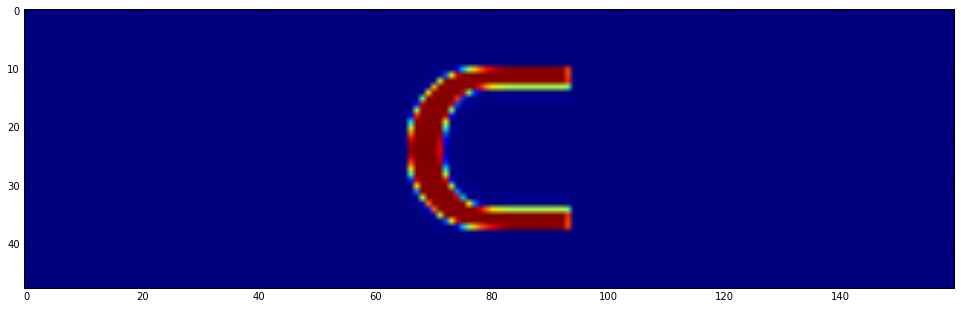

Label shape: (5, 11)
..C..


In [35]:
tmp = np.array(test_predictions)
print(tmp.shape)
for i in range(10):
    show_image(test_dataset_imgs[i])
    show_label(tmp[:, i, :])